In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader,random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [2]:
trfm = tt.Compose([
    tt.Resize((64,64)),
    tt.ToTensor()
])
dataset = ImageFolder('C://Users//mohda//Deep Learning Practice notebook//Malria Blood Cell//cell_images//train',transform=trfm)

In [3]:
len(dataset)

24958

In [4]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds, valid_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(valid_ds)

(19958, 5000)

In [5]:
batch_size = 128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

In [6]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:50],nrow=10).permute(1,2,0))
        break

torch.Size([3, 64, 64])


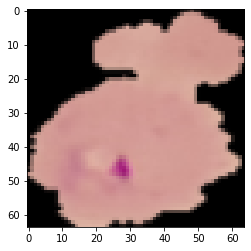

In [7]:

import matplotlib.pyplot as plt
for img in dataset[1]:
    plt.imshow(img.permute((1,2,0)))
    print(img.shape)
    break

In [8]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:50],nrow=10).permute(1,2,0))
        break

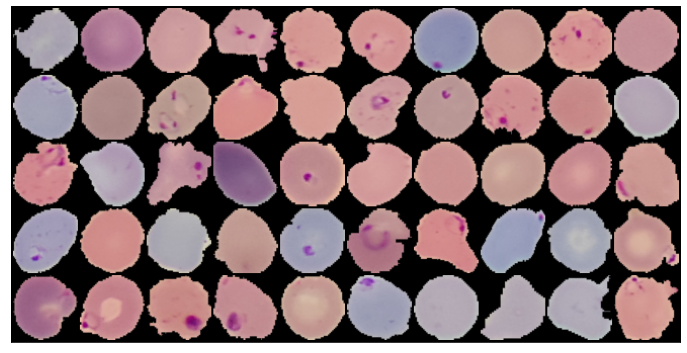

In [9]:
show_batch(dl=train_dl)

**Lets Build CNN Model**

In [10]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [11]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}] val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [12]:
class CNN(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output layer 128*32*32
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output layer 256*16*16

            nn.Conv2d(256,510,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output layer 510*8*8

            nn.Flatten(),
            nn.Linear(510*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self,xb):
        return self.network(xb)

In [13]:
model = CNN()

In [14]:
model.parameters

<bound method Module.parameters of CNN(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 510, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten()
    (12): Linear(in_features=32640, out_features=1024, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1024, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=2, bias=True)
  )
)>

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)

In [16]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)
to_device(model,device);

In [17]:
model = to_device(CNN(), device)

In [18]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


In [19]:
evaluate(model,valid_dl)

{'val_loss': 0.6930908560752869, 'val_acc': 0.506054699420929}

In [20]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [21]:
history = fit(5,0.003,model,train_dl,valid_dl)

Epoch [0] val_loss: 0.6844, val_acc: 0.5660
Epoch [1] val_loss: 0.6834, val_acc: 0.5652
Epoch [2] val_loss: 0.6130, val_acc: 0.6883
Epoch [3] val_loss: 0.2540, val_acc: 0.9092
Epoch [4] val_loss: 0.1567, val_acc: 0.9496


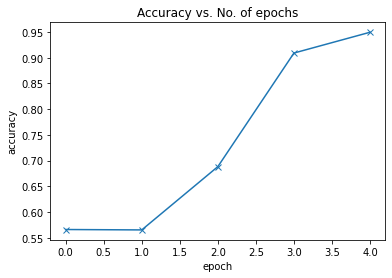

In [22]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

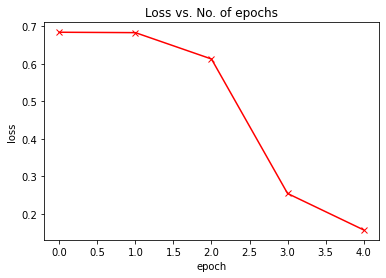

In [23]:

val_losses = [x['val_loss'] for x in history]
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [24]:
def predict_img(img,model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,preds = torch.max(yb,dim=1)
    return dataset.classes[preds[0].item()]

    
    '''
    It indicates the position on where to add the dimension. torch.unsqueeze adds an additional dimension to the tensor. So let's say you have a tensor of shape (3), if you add a dimension at the 0 position, it will be of shape (1,3), which means 1 row and 3 columns. If you add at the 1 position, it will be (3,1), which means 3 rows and 1 column. If you have a 2D tensor of shape (2,2) add add an extra dimension at the 0 position, this will result of the tensor having a shape of (1,2,2), which means one channel, 2 rows and 2 columns. If you add at the 1 position, it will be of shape (2,1,2), so it will have 2 channels, 1 row and 2 columns. If you add it at the 2 position, the tensor will be of shape (2,2,1), which means 2 channels, 2 rows and one column.


    '''

Label: parasitized , Predicted: parasitized


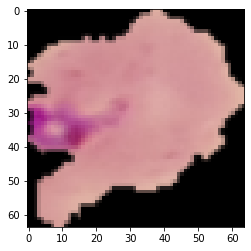

In [26]:
test_dataset = ImageFolder('C://Users//mohda//Deep Learning Practice notebook//Malria Blood Cell//cell_images//test', transform=trfm)
img, label = dataset[20]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_img(img, model))